In [1]:
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import cv2
import sys, os
DATA_COLLECTION_ROOT = "../data_collection/"
POS_SAMPLES = DATA_COLLECTION_ROOT + "pos_moles/cropped/"
NEG_SAMPLES = DATA_COLLECTION_ROOT + "neg_moles/cropped/"
%matplotlib inline

In [2]:
# Collect samples and sort them into positive and negative
# Augment data by having 4 rotations for each
pos_paths = []
neg_paths = []
for path in os.listdir(POS_SAMPLES):
    if path.endswith(".png"):
        pos_paths.append(POS_SAMPLES + path)
        
for path in os.listdir(NEG_SAMPLES):
    if path.endswith(".png"):
        neg_paths.append(NEG_SAMPLES + path)        

sample_img_shape = cv2.imread(pos_paths[0]).shape

all_x = []
all_y = []

for img_path in pos_paths:
    img = cv2.imread(img_path)
    if img.shape == sample_img_shape:
        rotations = 4
        #augment data by rotating 90 degrees 3 times since we have so few positives
        for i in range(rotations):
            img_flattened = img.flatten()
            all_x.append(img_flattened)
            all_y.append(1)
            image_center = tuple(np.array(img.shape)/2)[:2]
            rot_mat = cv2.getRotationMatrix2D(image_center,90, 1.0)
            img = cv2.warpAffine(img, rot_mat, img.shape[:2],flags=cv2.INTER_LINEAR)
            img[0] = img[1]
            img[:,0] = img[:,1]
            
for img_path in neg_paths:
    img = cv2.imread(img_path)
    if img.shape == sample_img_shape:
        rotations = 4
        #augment data by rotating 90 degrees 3 times since we have so few positives
        for i in range(rotations):
            img_flattened = img.flatten()
            all_x.append(img_flattened)
            all_y.append(0)
            image_center = tuple(np.array(img.shape)/2)[:2]
            rot_mat = cv2.getRotationMatrix2D(image_center,90, 1.0)
            img = cv2.warpAffine(img, rot_mat, img.shape[:2],flags=cv2.INTER_LINEAR)
            img[0] = img[1]
            img[:,0] = img[:,1]
            
all_x = np.array(all_x)
all_y = np.array(all_y)

In [23]:
# Randomize data order and separate into train/test data
data_indices = np.arange(len(all_x))
np.random.shuffle(data_indices)
train_indices = data_indices[:int(len(all_x)*.95)]
test_indices = data_indices[int(len(all_x)*.95):]
test_x = all_x[test_indices]
test_y = all_y[test_indices]
train_x = all_x[train_indices]
train_y = all_y[train_indices]

In [11]:
# Train a Random Forest Regressor (TAKE A LONG TIME)
rf_reg = RandomForestRegressor(n_estimators=50, n_jobs=-1)
rf_reg.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [34]:
# Calculate FPR and FNR for a single threshold
# Doesn't work as intended right now
fp = 0
fn = 0
predictions = [1 if prediction > 40/100.0 else 0 for prediction in rf_reg.predict(test_x)]

for i in range(len(predictions)):
    if predictions[i] == 1 and test_y[i] == 0:
        fp += 1
    elif predictions[i] == 0 and test_y[i] == 1:
        fn += 1

total_pos = sum(test_y)
total_neg = len(predictions) - total_pos
fpr = fp/float(total_neg)*100
fnr = fn/float(total_pos)*100
print("False Positive Rate: %f%%\nFalse Negative Rate: %f%%" 
      % (fpr, fnr))

False Positive Rate: 0.727273%
False Negative Rate: 0.000000%


In [26]:
# Make Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

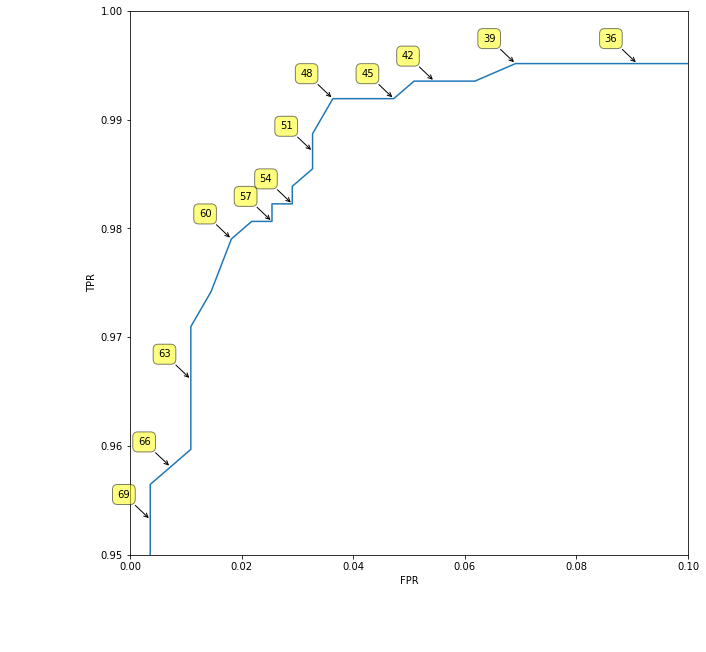

In [28]:
# Generate an ROC curve (TPR vs FPR) 
tp = []
fp = []
t_labels = []
y_pos = len(np.nonzero(test_y)[0])
y_neg = len(test_y) - y_pos
for t in range(0, 100):
    #predictions = [1 if prediction > t/100.0 else 0 for prediction in rf_reg.predict(test_x)]
    predictions = [1 if prediction > t/100.0 else 0 for prediction in rf_clf.predict_proba(test_x)[:,1]]
    tp_count = 0
    fp_count = 0
    for i in range(len(predictions)):
        if predictions[i] == 1 and test_y[i] == 1:
            tp_count += 1
        elif predictions[i] == 1 and test_y[i] == 0:
            fp_count += 1

    tp.append(tp_count/float(y_pos))
    fp.append(fp_count/float(y_neg))
    t_labels.append(t)
    
fig = plt.figure(figsize=(10,10))
plt.plot(fp, tp)
plt.ylabel("TPR")
plt.xlabel("FPR")
#plt.axis([0,1,0,1])
plt.axis([0,0.1,0.95,1])

for label, x, y in zip(t_labels, fp, tp):
    if label % 3 == 0:
        plt.annotate(
            str(label),
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


In [174]:

rf_clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
rf_clf.fit(train_x, train_y)
probs = rf_clf.predict_proba(test_x)[:,1]
predictions = [1 if prob > 0.3 else 0 for prob in probs]

for i in range(len(predictions)):
    if predictions[i] != test_y[i]:
        print str(predictions[i]) + ":" + str(test_y[i])

ValueError: Found array with 0 sample(s) (shape=(0, 7500)) while a minimum of 1 is required.

In [3]:
train_x = all_x
train_y = all_y
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_clf.fit(train_x, train_y)
joblib.dump(rf_clf, 'rf_clf.pkl')

['rf_clf.pkl']

In [ ]:
logreg = linear_model.LogisticRegression()
logreg.fit(train_x, train_y)
predictions = logreg.predict(test_x)
print sum(predictions)
print sum(test_y)
#print predictions - test_y
#print test_y